# RNN/LSTMハンズオン
日経平均を使った時系列データ予測にチャレンジ

In [73]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn.preprocessing as sp
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, SimpleRNN, GRU, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


# 描画を綺麗に表示する
from matplotlib.pylab import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 15, 6

print('matplotlib version :', matplotlib.__version__)
print('scipy version :', scipy.__version__)
print('numpy version :', np.__version__)
print('tensorflow version : ', tf.__version__)
print('keras version : ', keras.__version__)

matplotlib version : 3.2.1
scipy version : 1.5.3
numpy version : 1.19.5
tensorflow version :  1.15.5
keras version :  2.2.4-tf



日経新聞の以下のWebページから「日経平均株価」の「日次データ」をダウンロードする。
https://indexes.nikkei.co.jp/nkave/index?type=download

ダウンロードしたCSVファイル（nikkei_stock_average_daily_jp.csv）を左側のウインドウにドラッグアンドドロップし、アップロードする。

続いてファイル内容の確認を行う。

In [9]:
%%bash
head nikkei_stock_average_daily_jp.csv

�f�[�^���t,�I�l,�n�l,���l,���l
"2018/01/04","23506.33","23073.73","23506.33","23065.20"
"2018/01/05","23714.53","23643.00","23730.47","23520.52"
"2018/01/09","23849.99","23948.97","23952.61","23789.03"
"2018/01/10","23788.20","23832.81","23864.76","23755.45"
"2018/01/11","23710.43","23656.39","23734.97","23601.84"
"2018/01/12","23653.82","23719.66","23743.05","23588.07"
"2018/01/15","23714.88","23827.98","23833.27","23685.02"
"2018/01/16","23951.81","23721.17","23962.07","23701.83"
"2018/01/17","23868.34","23783.42","23891.63","23739.17"


In [3]:
#文字エンコーディングが対応していないため、タイトル行が文字化けしてしまっているので、エンコードを変換。
import codecs

sf = codecs.open('nikkei_stock_average_daily_jp.csv', 'r', encoding='shift-jis')
uf = codecs.open('nikkei_utf8.csv', 'w', encoding='utf-8')
for line in sf:
    uf.write(line)
sf.close()
uf.close()

修正結果の確認

In [10]:
%%bash
head nikkei_utf8.csv

データ日付,終値,始値,高値,安値
"2018/01/04","23506.33","23073.73","23506.33","23065.20"
"2018/01/05","23714.53","23643.00","23730.47","23520.52"
"2018/01/09","23849.99","23948.97","23952.61","23789.03"
"2018/01/10","23788.20","23832.81","23864.76","23755.45"
"2018/01/11","23710.43","23656.39","23734.97","23601.84"
"2018/01/12","23653.82","23719.66","23743.05","23588.07"
"2018/01/15","23714.88","23827.98","23833.27","23685.02"
"2018/01/16","23951.81","23721.17","23962.07","23701.83"
"2018/01/17","23868.34","23783.42","23891.63","23739.17"


In [30]:
df = pd.read_csv('nikkei_utf8.csv')

In [8]:
df.head()

,データ日付,終値,始値,高値,安値
0,2018/01/04,23506.33,23073.73,23506.33,23065.20
1,2018/01/05,23714.53,23643.00,23730.47,23520.52
2,2018/01/09,23849.99,23948.97,23952.61,23789.03
3,2018/01/10,23788.20,23832.81,23864.76,23755.45
4,2018/01/11,23710.43,23656.39,23734.97,23601.84


In [31]:
#カラム名を英名に変更
df.set_axis(["date", "close", "open", "high", "low"], axis="columns", inplace=True)

In [13]:
df.tail()

,date,close,open,high,low
937,2021/11/09,29285.46,29557.55,29750.46,29240.31
938,2021/11/10,29106.78,29209.06,29296.88,29079.77
939,2021/11/11,29277.86,29046.19,29336.03,29040.08
940,2021/11/12,29609.97,29381.45,29661.22,29381.45
941,本資料は日経の著作物であり、本資料の全部又は一部を、いかなる形式によっても日経に無断で複写、...,NaN,NaN,NaN,NaN


In [32]:
#最終行に不要データがあるため削除。
df.drop(index=df.index[-1], inplace=True)

In [15]:
df.tail()

,date,close,open,high,low
936,2021/11/08,29507.05,29735.45,29735.45,29507.05
937,2021/11/09,29285.46,29557.55,29750.46,29240.31
938,2021/11/10,29106.78,29209.06,29296.88,29079.77
939,2021/11/11,29277.86,29046.19,29336.03,29040.08
940,2021/11/12,29609.97,29381.45,29661.22,29381.45


In [33]:
#全データの再確認
print(df)
print(df.describe())

           date     close      open      high       low
0    2018/01/04  23506.33  23073.73  23506.33  23065.20
1    2018/01/05  23714.53  23643.00  23730.47  23520.52
2    2018/01/09  23849.99  23948.97  23952.61  23789.03
3    2018/01/10  23788.20  23832.81  23864.76  23755.45
4    2018/01/11  23710.43  23656.39  23734.97  23601.84
..          ...       ...       ...       ...       ...
936  2021/11/08  29507.05  29735.45  29735.45  29507.05
937  2021/11/09  29285.46  29557.55  29750.46  29240.31
938  2021/11/10  29106.78  29209.06  29296.88  29079.77
939  2021/11/11  29277.86  29046.19  29336.03  29040.08
940  2021/11/12  29609.97  29381.45  29661.22  29381.45

[941 rows x 5 columns]
              close          open          high           low
count    941.000000    941.000000    941.000000    941.000000
mean   23728.019469  23728.990043  23852.031668  23594.463964
std     3117.915997   3118.421745   3126.740543   3116.517331
min    16552.830000  16570.570000  17049.030000  16358.1

In [34]:
#データの正規化
df['close_norm'] = sp.minmax_scale(df['close'])
print(df.describe())

              close          open          high           low  close_norm
count    941.000000    941.000000    941.000000    941.000000  941.000000
mean   23728.019469  23728.990043  23852.031668  23594.463964    0.508256
std     3117.915997   3118.421745   3126.740543   3116.517331    0.220858
min    16552.830000  16570.570000  17049.030000  16358.190000    0.000000
25%    21587.780000  21579.680000  21686.530000  21490.020000    0.356652
50%    22694.660000  22686.950000  22796.140000  22563.560000    0.435058
75%    26436.390000  26468.520000  26585.210000  26327.080000    0.700104
max    30670.100000  30606.150000  30795.780000  30504.810000    1.000000


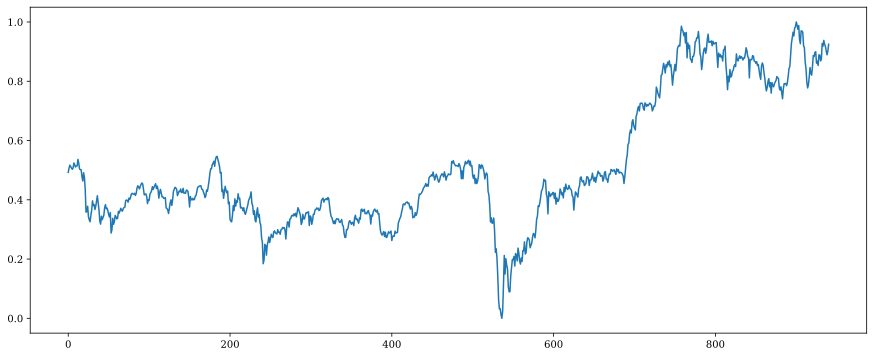

In [35]:
plt.plot(df['close_norm'])

In [36]:
#訓練、テストデータの作成

#データセットのサイズを決める。今回は10個のデータから次の１個を予測するためのデータセットを作る。
maxlen = 10
X, Y = [], []
for i in range(len(df) - maxlen):
    X.append(df[['close_norm']].iloc[i:(i+maxlen)].values)
    Y.append(df[['close_norm']].iloc[i+maxlen].values)
X=np.array(X)
Y=np.array(Y)

In [37]:
print(X.shape)
print(Y.shape)

(931, 10, 1)
(931, 1)


In [38]:
print(X[0])
print(Y[0])

[[0.49255274]
 [0.50730063]
 [0.51689597]
 [0.51251906]
 [0.50701021]
 [0.50300023]
 [0.50732542]
 [0.52410841]
 [0.5181958 ]
 [0.51076022]]
[0.51392585]


In [39]:
print(X[1])
print(Y[1])

[[0.50730063]
 [0.51689597]
 [0.51251906]
 [0.50701021]
 [0.50300023]
 [0.50732542]
 [0.52410841]
 [0.5181958 ]
 [0.51076022]
 [0.51392585]]
[0.51451166]


In [40]:
# 訓練用のデータと、テスト用のデータに分ける
N_train = int(len(df) * 0.8)
N_test = len(df) - N_train
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=N_test, shuffle = False) 

In [66]:
# 隠れ層の数などを定義: 隠れ層の数が大きいほど精度が上がる?
n_in = 1 # len(X[0][0])
n_out = 1 # len(Y[0])
n_hidden = 500
epochs = 30

#モデル作成 (Kerasのフレームワークで簡易に記載できる)
model = Sequential()
model.add(SimpleRNN(n_hidden, activation="tanh", 
                    batch_input_shape=(None, maxlen, n_in)))
model.add(Dense(n_in, kernel_initializer='random_uniform'))
model.add(Activation("linear"))

model.compile(optimizer='sgd',                 # 最適化手法
              loss='mean_squared_error')       # 損失関数

hist = model.fit(X_train, y_train, batch_size=maxlen, epochs=epochs, verbose=1)

Epoch 1/30
742/742 [==============================] - 2s 2ms/step - loss: 0.0077
Epoch 2/30
742/742 [==============================] - 1s 986us/step - loss: 0.0029
Epoch 3/30
742/742 [==============================] - 1s 1ms/step - loss: 0.0024
Epoch 4/30
742/742 [==============================] - 1s 972us/step - loss: 0.0023
Epoch 5/30
742/742 [==============================] - 1s 1ms/step - loss: 0.0022
Epoch 6/30
742/742 [==============================] - 1s 1ms/step - loss: 0.0021
Epoch 7/30
742/742 [==============================] - 1s 1ms/step - loss: 0.0020
Epoch 8/30
742/742 [==============================] - 1s 1ms/step - loss: 0.0019
Epoch 9/30
742/742 [==============================] - 1s 1ms/step - loss: 0.0019
Epoch 10/30
742/742 [==============================] - 1s 1ms/step - loss: 0.0018
Epoch 11/30
742/742 [==============================] - 1s 987us/step - loss: 0.0017
Epoch 12/30
742/742 [==============================] - 1s 1ms/step - loss: 0.0016
Epoch 13/30
742/742

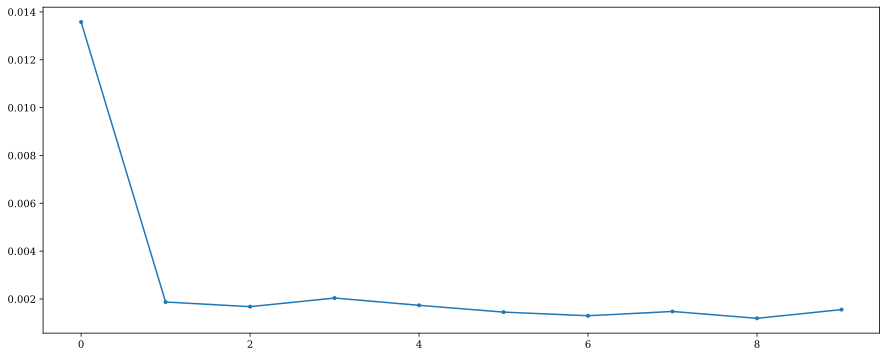

In [111]:
# 損失のグラフ化（モデルがどれだけ予測出来ていないかの指標。０に近づくほどモデルの精度が良い。
# ※推定を行う場合はAccuracyではなく、Lossでみる。
loss = hist.history['loss']
epochs = len(loss)
plt.rc('font', family='serif')
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(range(epochs), loss, marker='.', label='loss(training data)')
plt.show()

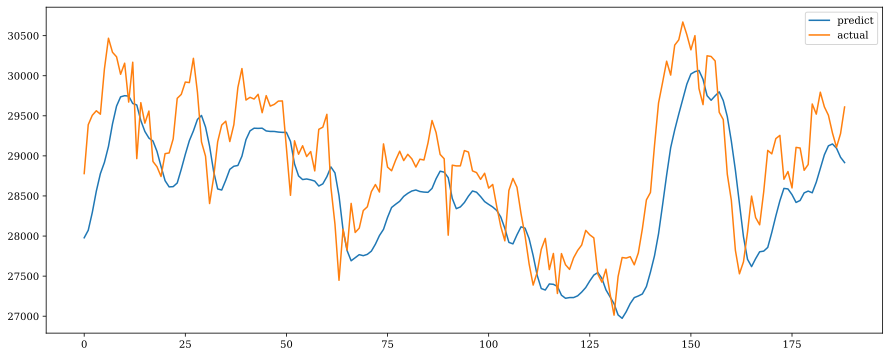

,date,actual,predict
0,2021/02/05,28779.19,27978.101562
1,2021/02/08,29388.50,28071.830078
2,2021/02/09,29505.93,28293.031250
3,2021/02/10,29562.93,28560.472656
4,2021/02/12,29520.07,28777.878906
...,...,...,...
184,2021/11/08,29507.05,29125.363281
185,2021/11/09,29285.46,29148.808594
186,2021/11/10,29106.78,29095.621094
187,2021/11/11,29277.86,28982.542969


In [112]:
# 予測結果
predicted = model.predict(X_test)
result = pd.DataFrame(predicted)
result.columns = ['predict']
result['actual'] = y_test

#正規化していた数値を金額に再変換する
result['predict']=((df['close'].max()-df['close'].min())*result['predict'])+df['close'].min()
result['actual']=((df['close'].max()-df['close'].min())*result['actual'])+df['close'].min()
result.plot()
plt.show()

#平均値でオフセット
#result['predict']=result['predict']-(result['predict'].mean()-result['actual'].mean())

date=np.array(df.loc[len(df)-len(X_test):len(df),['date']])
result['date']=np.array(date)

result.loc[:,['date','actual','predict']]

大事なのは値が推定できているかではない。

儲かるかどうかだ！

結局儲かるの？

In [113]:
#売買シミュレーションを作る
bitprice=np.array(df.loc[len(df)-len(X_test):len(df),['open']])
result['bitprice']=np.array(bitprice)
result['Judge'] = False
result['Rev'] = 0
result['Hit'] = False
result['totalRev'] = 0
total_rev=0

# Collumn Ref
# 0:predict 1:actual 2:date 3:bitprice 4:Judge 5:Rev 6:hit 7:totalRev 
for index in range(len(result)-1):
    if (result.iat[index+1, 0]>result.iat[index, 1]):    #当日の実終値よりも明日の予想終値が高い場合
        result.iat[index+1, 4]=True                      #買う判断をする
        result.iat[index+1, 5]=result.iat[index+1, 1]-result.iat[index+1, 3]    #翌日の初値で購入し、終値で売った金額がその日の儲け
        if result.iat[index+1, 5]>0:
            result.iat[index+1, 6]=True                  #モデル評価用に値上がり判断が妥当だったかを判定
        total_rev=total_rev+result.iat[index+1, 5]       #差額を累積利益に算入
    result.iat[index+1, 7]=total_rev                     #累積利益をresult表に追加

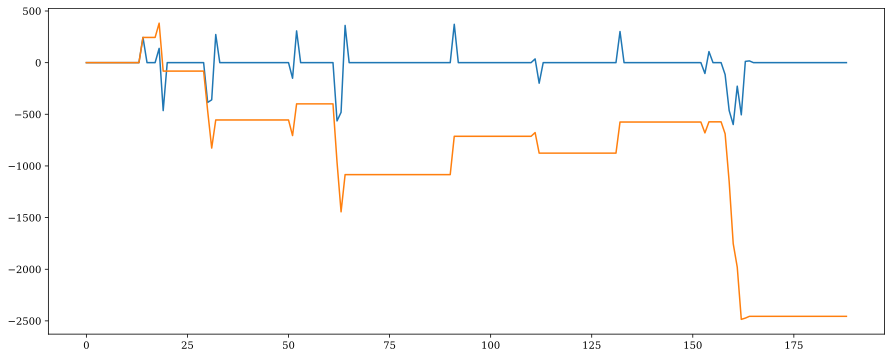

,date,actual,predict,bitprice,Judge,Rev,Hit,totalRev
0,2021/02/05,28779.19,27978.101562,28631.46,False,0,False,0
1,2021/02/08,29388.50,28071.830078,28831.58,False,0,False,0
2,2021/02/09,29505.93,28293.031250,29435.61,False,0,False,0
3,2021/02/10,29562.93,28560.472656,29412.55,False,0,False,0
4,2021/02/12,29520.07,28777.878906,29635.88,False,0,False,0
...,...,...,...,...,...,...,...,...
184,2021/11/08,29507.05,29125.363281,29735.45,False,0,False,-2456
185,2021/11/09,29285.46,29148.808594,29557.55,False,0,False,-2456
186,2021/11/10,29106.78,29095.621094,29209.06,False,0,False,-2456
187,2021/11/11,29277.86,28982.542969,29046.19,False,0,False,-2456


In [114]:
result['Rev'].plot()
result['totalRev'].plot()
plt.show()

result.loc[:,['date','actual','predict','bitprice','Judge','Rev','Hit','totalRev']]

In [115]:
#売買シミュレーション結果まとめ
judgeTrue = result['Judge'] == True
hitTrue = result['Hit'] == True

print("判断回数: "+str(len(result)))
print("取引回数: "+str(judgeTrue.sum()))
print("利益獲得回数: "+str(hitTrue.sum()))
print("勝率:　"+str(hitTrue.sum()/judgeTrue.sum()))
print("最終利益： ￥"+str(total_rev)+"/単元")

判断回数: 189
取引回数: 24
利益獲得回数: 11
勝率:　0.4583333333333333
最終利益： ￥-2456/単元



## __RNN以外の時系列モデルを使ってみる。（おまけ）__
RNNより新しいLSTMモデルでのトライアル。

In [120]:
# 隠れ層の数などを定義: 隠れ層の数が大きいほど精度が上がる?
n_in = 1 # len(X[0][0])
n_out = 1 # len(Y[0])
n_hidden = 500

#モデル作成 (Kerasのフレームワークで簡易に記載できる)
model = Sequential()
model.add(LSTM(n_hidden,
               batch_input_shape=(None, maxlen, n_in),
               kernel_initializer='random_uniform',
               return_sequences=False))
model.add(Dense(n_in, kernel_initializer='random_uniform'))
#model.add(Activation("linear"))

#opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
opt = Adam()                                   # 最適化手法の設定
model.compile(optimizer = opt,                 # 最適化手法
              loss = 'mean_squared_error',     # 損失関数
              )

early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)
hist = model.fit(X_train, y_train, batch_size=maxlen, epochs=10,
                 callbacks=[early_stopping])

Epoch 1/10
742/742 [==============================] - 7s 10ms/step - loss: 0.0113
Epoch 2/10
742/742 [==============================] - 4s 5ms/step - loss: 0.0018
Epoch 3/10
742/742 [==============================] - 4s 5ms/step - loss: 0.0016
Epoch 4/10
742/742 [==============================] - 4s 5ms/step - loss: 0.0031
Epoch 5/10
742/742 [==============================] - 4s 5ms/step - loss: 0.0015
Epoch 6/10
742/742 [==============================] - 4s 5ms/step - loss: 0.0017
Epoch 7/10
742/742 [==============================] - 4s 5ms/step - loss: 0.0013
Epoch 8/10
742/742 [==============================] - 4s 5ms/step - loss: 0.0013
Epoch 9/10
742/742 [==============================] - 4s 5ms/step - loss: 0.0011
Epoch 10/10
742/742 [==============================] - 4s 5ms/step - loss: 0.0011


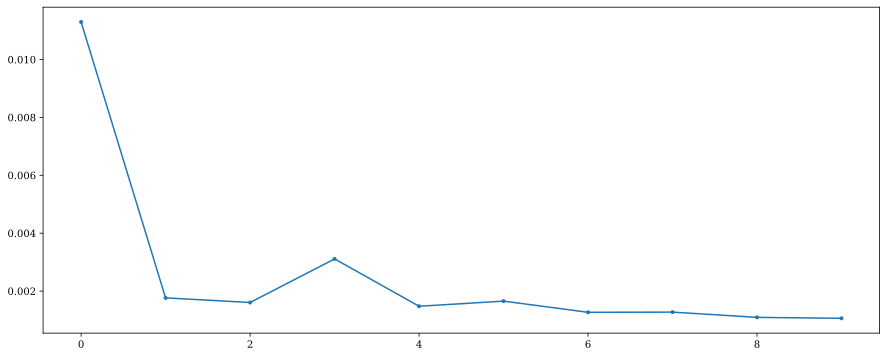

In [121]:
# 損失のグラフ化（モデルがどれだけ予測出来ていないかの指標。０に近づくほどモデルの精度が良い。
# ※推定を行う場合はAccuracyではなく、Lossでみる。
loss = hist.history['loss']
epochs = len(loss)
plt.rc('font', family='serif')
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(range(epochs), loss, marker='.', label='loss(training data)')
plt.show()

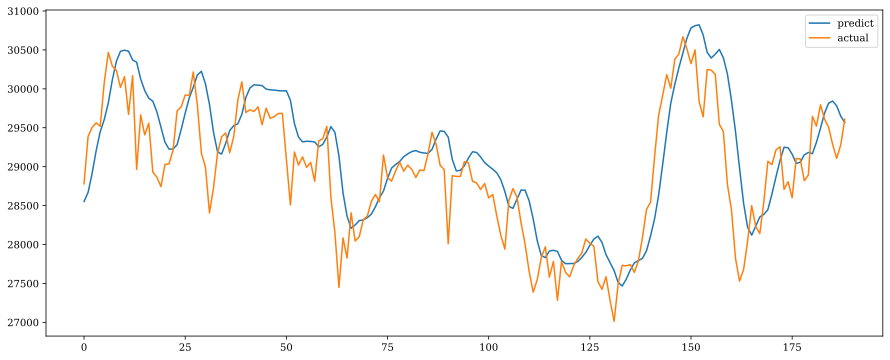

,date,actual,predict
0,2021/02/05,28779.19,28552.691406
1,2021/02/08,29388.50,28669.189453
2,2021/02/09,29505.93,28914.074219
3,2021/02/10,29562.93,29206.539062
4,2021/02/12,29520.07,29449.140625
...,...,...,...
184,2021/11/08,29507.05,29814.984375
185,2021/11/09,29285.46,29843.601562
186,2021/11/10,29106.78,29781.769531
187,2021/11/11,29277.86,29650.167969


In [122]:
# 予測結果
predicted = model.predict(X_test)
result = pd.DataFrame(predicted)
result.columns = ['predict']
result['actual'] = y_test

#正規化していた数値を金額に再変換する
result['predict']=((df['close'].max()-df['close'].min())*result['predict'])+df['close'].min()
result['actual']=((df['close'].max()-df['close'].min())*result['actual'])+df['close'].min()

#平均値でオフセット
#result['predict']=result['predict']-(result['predict'].mean()-result['actual'].mean())

result.plot()
plt.show()

date=np.array(df.loc[len(df)-len(X_test):len(df),['date']])
result['date']=np.array(date)

result.loc[:,['date','actual','predict']]

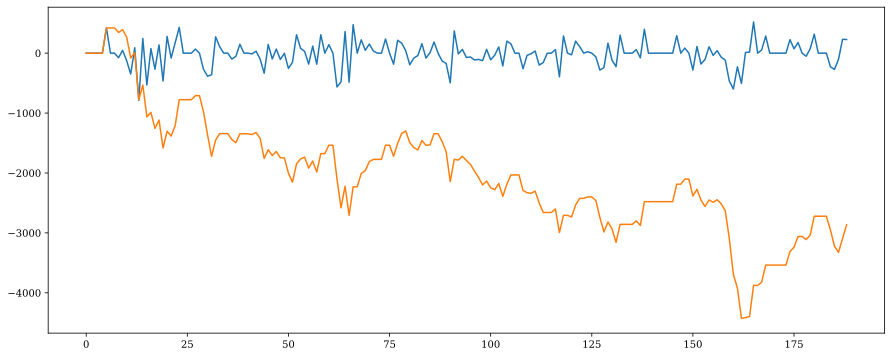

,date,actual,predict,bitprice,Judge,Rev,Hit,totalRev
0,2021/02/05,28779.19,28552.691406,28631.46,False,0,False,0
1,2021/02/08,29388.50,28669.189453,28831.58,False,0,False,0
2,2021/02/09,29505.93,28914.074219,29435.61,False,0,False,0
3,2021/02/10,29562.93,29206.539062,29412.55,False,0,False,0
4,2021/02/12,29520.07,29449.140625,29635.88,False,0,False,0
...,...,...,...,...,...,...,...,...
184,2021/11/08,29507.05,29814.984375,29735.45,True,-228,False,-2950
185,2021/11/09,29285.46,29843.601562,29557.55,True,-272,False,-3222
186,2021/11/10,29106.78,29781.769531,29209.06,True,-102,False,-3324
187,2021/11/11,29277.86,29650.167969,29046.19,True,231,True,-3093


In [124]:
#売買シミュレーションを作る
bitprice=np.array(df.loc[len(df)-len(X_test):len(df),['open']])
result['bitprice']=np.array(bitprice)
result['Judge'] = False
result['Rev'] = 0
result['Hit'] = False
result['totalRev'] = 0
total_rev=0

# Collumn Ref
# 0:predict 1:actual 2:date 3:bitprice 4:Judge 5:Rev 6:hit 7:totalRev 
for index in range(len(result)-1):
    if (result.iat[index+1, 0]>result.iat[index, 1]):    #当日の実終値よりも明日の予想終値が高い場合
        result.iat[index+1, 4]=True                      #買う判断をする
        result.iat[index+1, 5]=result.iat[index+1, 1]-result.iat[index+1, 3]    #翌日の初値で購入し、終値で売った金額がその日の儲け
        if result.iat[index+1, 5]>0:
            result.iat[index+1, 6]=True                  #モデル評価用に値上がり判断が妥当だったかを判定
        total_rev=total_rev+result.iat[index+1, 5]       #差額を累積利益に算入
    result.iat[index+1, 7]=total_rev                     #累積利益をresult表に追加
    

result['Rev'].plot()
result['totalRev'].plot()
plt.show()

result.loc[:,['date','actual','predict','bitprice','Judge','Rev','Hit','totalRev']]

In [125]:
#売買シミュレーション結果まとめ(LSTM)
judgeTrue = result['Judge'] == True
hitTrue = result['Hit'] == True

print("判断回数: "+str(len(result)))
print("取引回数: "+str(judgeTrue.sum()))
print("利益獲得回数: "+str(hitTrue.sum()))
print("勝率:　"+str(hitTrue.sum()/judgeTrue.sum()))
print("最終利益： ￥"+str(total_rev)+"/単元")

判断回数: 189
取引回数: 139
利益獲得回数: 69
勝率:　0.49640287769784175
最終利益： ￥-2865/単元
